In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"razrstark","key":"16b43f5089eab981148f1bccfb2b09e4"}'}

In [2]:
# Step 2: Configure Kaggle API
import os

# Create the .kaggle directory in the root directory
kaggle_dir = '/root/.kaggle'
os.makedirs(kaggle_dir, exist_ok=True)

# Move the kaggle.json file to the .kaggle directory
!mv kaggle.json {kaggle_dir}

# Change the file permissions
os.chmod(f'{kaggle_dir}/kaggle.json', 0o600)  # Use octal notation for permissions

In [3]:
!kaggle datasets download -d yasserh/uber-fares-dataset

Dataset URL: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset
License(s): CC0-1.0
 99% 7.00M/7.04M [00:01<00:00, 7.87MB/s]
100% 7.04M/7.04M [00:01<00:00, 4.86MB/s]


In [5]:
!unzip uber-fares-dataset.zip

Archive:  uber-fares-dataset.zip
  inflating: uber.csv                


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Load the dataset
data = pd.read_csv('uber.csv')

In [10]:
# Display basic info and check for missing data
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None
         Unnamed: 0    fare_amount  pickup_longitude  pickup_latitude  \
count  2.000000e+05  200000.000000     200000.000000    200000.000000   
mean   2.771250e+07      11.359955        -72.527638        39.935885   
std    1.601382e+07       9.901776         11.437787         7.7

In [15]:
data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


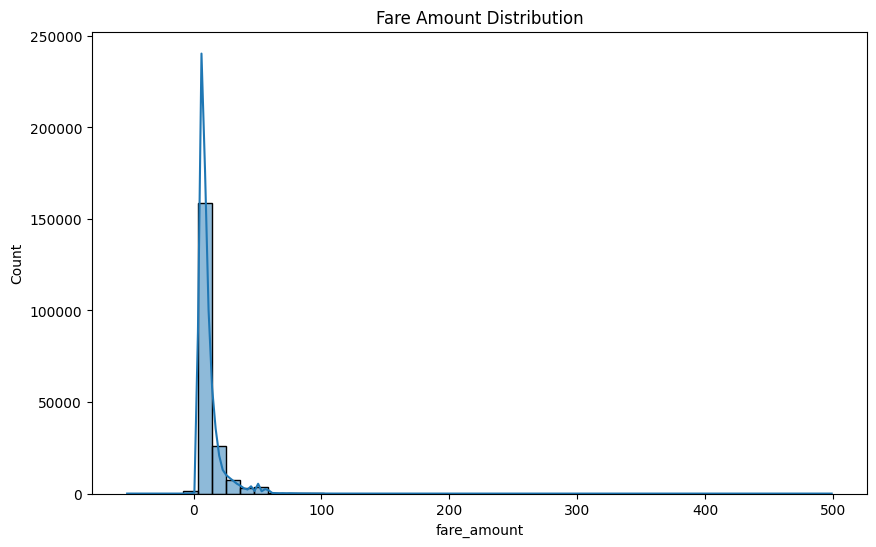

In [11]:
# Visualize target variable distribution (fare amount)
plt.figure(figsize=(10,6))
sns.histplot(data['fare_amount'], bins=50, kde=True)
plt.title('Fare Amount Distribution')
plt.show()

In [12]:
import numpy as np
from geopy.distance import geodesic

In [14]:
# Clean up invalid data (negative fares, unrealistic passenger counts)
data = data[(data['fare_amount'] > 0) & (data['passenger_count'] > 0) & (data['passenger_count'] <= 6)]
data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [20]:
# Convert 'pickup_datetime' to datetime
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
print(data['pickup_datetime'])

0        2015-05-07 19:52:06+00:00
1        2009-07-17 20:04:56+00:00
2        2009-08-24 21:45:00+00:00
3        2009-06-26 08:22:21+00:00
4        2014-08-28 17:47:00+00:00
                    ...           
199995   2012-10-28 10:49:00+00:00
199996   2014-03-14 01:09:00+00:00
199997   2009-06-29 00:42:00+00:00
199998   2015-05-20 14:56:25+00:00
199999   2010-05-15 04:08:00+00:00
Name: pickup_datetime, Length: 199268, dtype: datetime64[ns, UTC]


In [21]:
# Extract time-based features
data['hour'] = data['pickup_datetime'].dt.hour
data['day'] = data['pickup_datetime'].dt.day
data['month'] = data['pickup_datetime'].dt.month
data['weekday'] = data['pickup_datetime'].dt.weekday

In [24]:
# Calculate distance using Haversine formula
def haversine_distance(row):
    # Ensure latitude values are within the valid range
    start_lat = max(min(row['pickup_latitude'], 90), -90)  # Clip latitude to [-90, 90]
    end_lat = max(min(row['dropoff_latitude'], 90), -90)  # Clip latitude to [-90, 90]

    start = (start_lat, row['pickup_longitude'])
    end = (end_lat, row['dropoff_longitude'])
    return geodesic(start, end).km

In [25]:
data['distance_km'] = data.apply(haversine_distance, axis=1)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
# Define input features and target variable
X = data[['distance_km', 'passenger_count', 'hour', 'day', 'month', 'weekday']]
y = data['fare_amount']

In [28]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [30]:
# Train Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [32]:
# Predict and evaluate
y_pred = lin_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression RMSE: {rmse}, R2: {r2}")

Linear Regression RMSE: 10.179507642669694, R2: 0.0014584173625173946


In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
# Train Random Forest model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [35]:
# Predict and evaluate
y_pred_rf = rf_reg.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest RMSE: {rmse_rf}, R2: {r2_rf}")

Random Forest RMSE: 5.723476405447517, R2: 0.6843306593324412


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [37]:
# Build Neural Network model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Single output for fare amount

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
3986/3986 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 687.9529 - val_loss: 33.6993
Epoch 2/20
3986/3986 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 31.1744 - val_loss: 23.8374
Epoch 3/20
3986/3986 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 32.7811 - val_loss: 23.2370
Epoch 4/20
3986/3986 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 30.4314 - val_loss: 25.9609
Epoch 5/20
3986/3986 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 30.7230 - val_loss: 23.7848
Epoch 6/20
3986/3986 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 27.9737 - val_loss: 24.1746
Epoch 7/20
3986/3986 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 30.6338 - val_loss: 22.9399
Epoch 8/20
3986/3986 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 27.4498 - val_loss: 23.1870
Epoch 9/20
3986/3986 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 30.5442 - val_loss: 22.6571
Epoch 10/20
3986/3986 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 27.6566 - val_loss: 22.7727
Epoch 11/20
3986/3986 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 26.6937 - val_loss: 22.9426
Ep

In [40]:
# Predict and evaluate
y_pred_nn = model.predict(X_test)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
print(f"Neural Network RMSE: {rmse_nn}")

1246/1246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Neural Network RMSE: 5.725196326471083


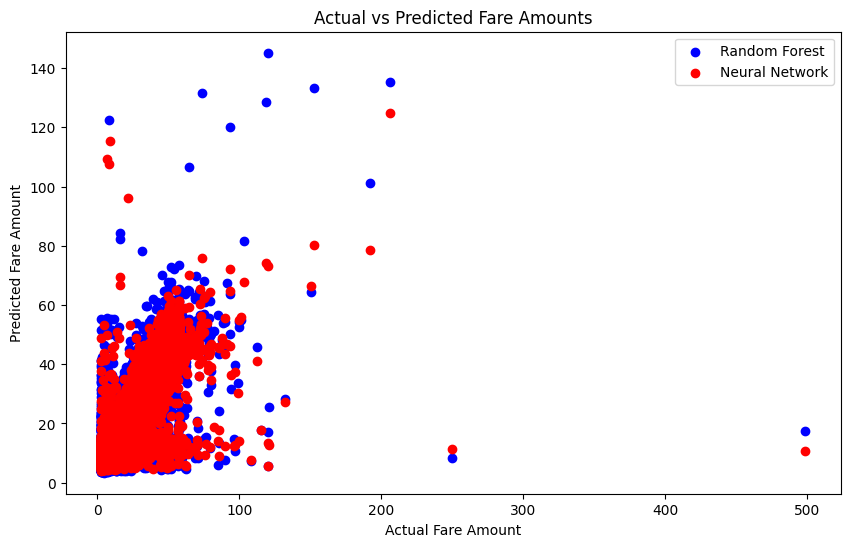

In [41]:
# Compare actual vs predicted values
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rf, color='blue', label='Random Forest')
plt.scatter(y_test, y_pred_nn, color='red', label='Neural Network')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.legend()
plt.title('Actual vs Predicted Fare Amounts')
plt.show()